In [1]:
# train a classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Flatten, BatchNormalization
from matplotlib import pyplot

In [2]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1, alpha=0.2, dropout=0.2):
    model = Sequential()
        
    model.add(Dense(200, use_bias=False, input_dim=n_inputs))
    model.add(Reshape((10,10,2)))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(8, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))

    model.add(Flatten())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout)) 

    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1, alpha=0.2):
    model = Sequential()

    model.add(Dense(200, input_dim=latent_dim, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Reshape((10,10,2)))

    model.add(Conv2DTranspose(32, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(16, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(8, kernel_size=3, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Flatten())

    model.add(Dense(n_outputs, activation='tanh'))
    
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adagrad')
    return model
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.25, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(generator, latent_dim, samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # predict outputs
    X = generator.predict(x_input)
    # shape array
    X = X.reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake samples
def summarize_performance(epoch, generator, discriminator, latent_dim, samples, nbins):
    # prepare real samples
    x_real, y_real = generate_real_samples(100000)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100000)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    #yplot.hist(x_real, color='red', label='real', alpha=0.5)
    #yplot.hist(x_fake, color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()
    

    # serialize weights to HDF5
    generator.save_weights(str(epoch)+"_generator.h5")
    print("Saved generator to disk")
    discriminator.save_weights(str(epoch)+"_discriminator.h5")
    print("Saved discriminator to disk")
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=30000, samples=256, nbins=49, n_eval=250):
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_samples)
        # update discriminator
        d_model.trainable = True
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, samples)
        # create inverted labels for the fake samples
        y_gan = np.ones((samples, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, samples, nbins)

epoch:  249 acc_real:  0.6550400257110596 acc_fake:  0.6787300109863281


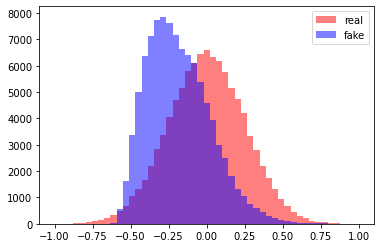

Saved generator to disk
Saved discriminator to disk
epoch:  499 acc_real:  0.9854599833488464 acc_fake:  0.3777399957180023


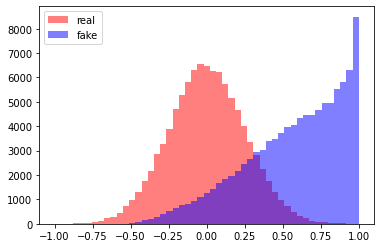

Saved generator to disk
Saved discriminator to disk
epoch:  749 acc_real:  0.8755499720573425 acc_fake:  0.3843599855899811


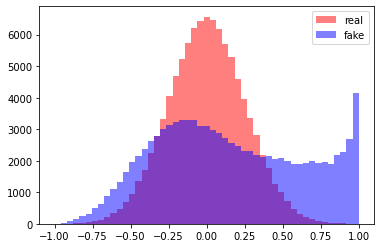

Saved generator to disk
Saved discriminator to disk
epoch:  999 acc_real:  0.9675400257110596 acc_fake:  0.14695000648498535


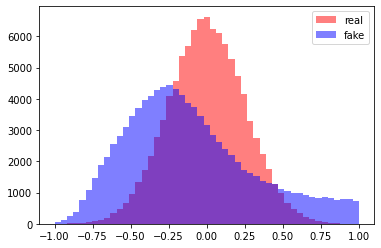

Saved generator to disk
Saved discriminator to disk
epoch:  1249 acc_real:  0.9446099996566772 acc_fake:  0.18708999454975128


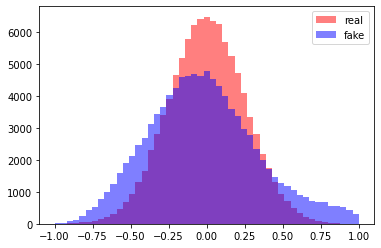

Saved generator to disk
Saved discriminator to disk
epoch:  1499 acc_real:  0.9248499870300293 acc_fake:  0.15153999626636505


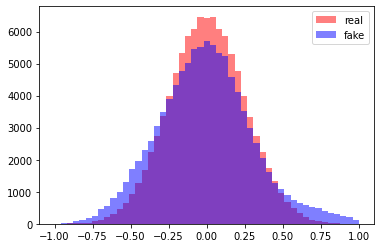

Saved generator to disk
Saved discriminator to disk
epoch:  1749 acc_real:  0.9120500087738037 acc_fake:  0.11912000179290771


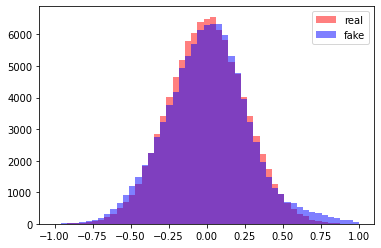

Saved generator to disk
Saved discriminator to disk
epoch:  1999 acc_real:  0.902970016002655 acc_fake:  0.09335000067949295


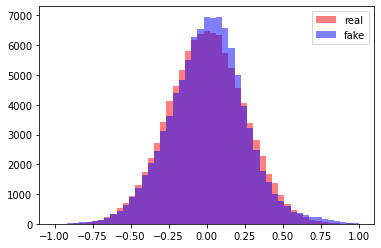

Saved generator to disk
Saved discriminator to disk
epoch:  2249 acc_real:  0.9069600105285645 acc_fake:  0.07175000011920929


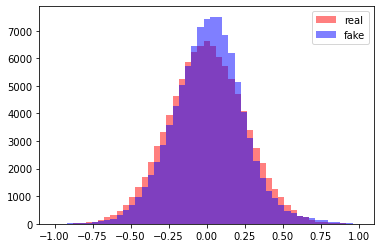

Saved generator to disk
Saved discriminator to disk
epoch:  2499 acc_real:  0.9175900220870972 acc_fake:  0.051750000566244125


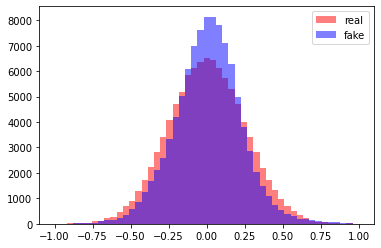

Saved generator to disk
Saved discriminator to disk
epoch:  2749 acc_real:  0.9291499853134155 acc_fake:  0.03485000133514404


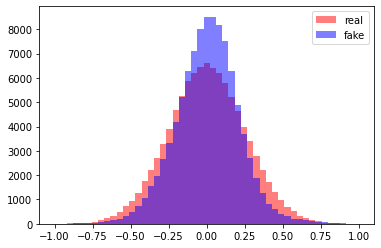

Saved generator to disk
Saved discriminator to disk
epoch:  2999 acc_real:  0.9455299973487854 acc_fake:  0.023879999294877052


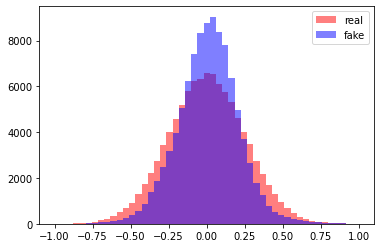

Saved generator to disk
Saved discriminator to disk
epoch:  3249 acc_real:  0.9588099718093872 acc_fake:  0.015530000440776348


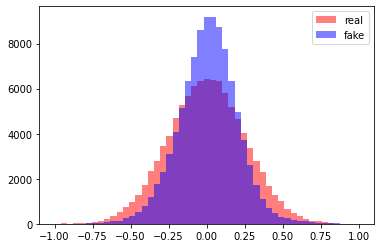

Saved generator to disk
Saved discriminator to disk
epoch:  3499 acc_real:  0.9720900058746338 acc_fake:  0.009669999592006207


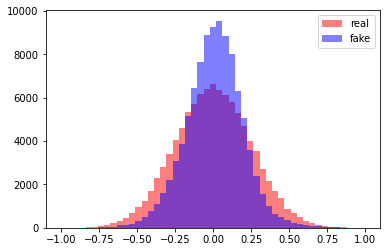

Saved generator to disk
Saved discriminator to disk
epoch:  3749 acc_real:  0.9807800054550171 acc_fake:  0.0067900000140070915


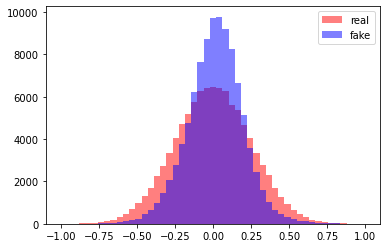

Saved generator to disk
Saved discriminator to disk
epoch:  3999 acc_real:  0.9854300022125244 acc_fake:  0.004220000002533197


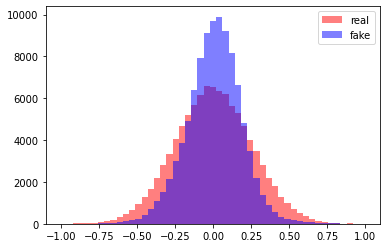

Saved generator to disk
Saved discriminator to disk
epoch:  4249 acc_real:  0.9901900291442871 acc_fake:  0.0028899998869746923


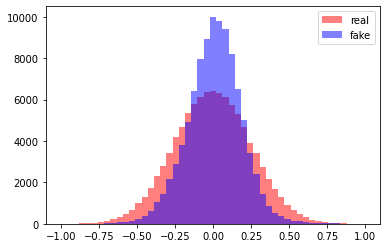

Saved generator to disk
Saved discriminator to disk
epoch:  4499 acc_real:  0.9921600222587585 acc_fake:  0.0017000000225380063


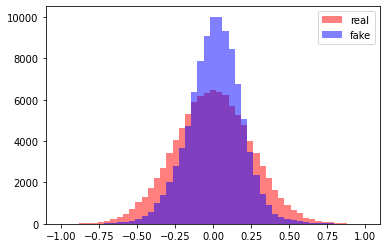

Saved generator to disk
Saved discriminator to disk
epoch:  4749 acc_real:  0.9940599799156189 acc_fake:  0.0012499999720603228


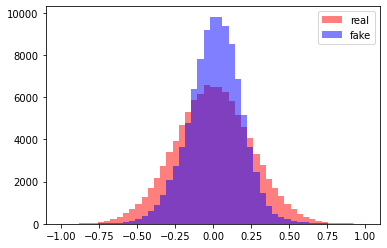

Saved generator to disk
Saved discriminator to disk
epoch:  4999 acc_real:  0.9956600069999695 acc_fake:  0.0008699999889358878


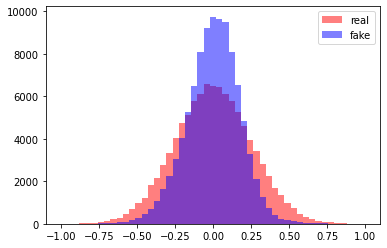

Saved generator to disk
Saved discriminator to disk
epoch:  5249 acc_real:  0.996969997882843 acc_fake:  0.0003499999875202775


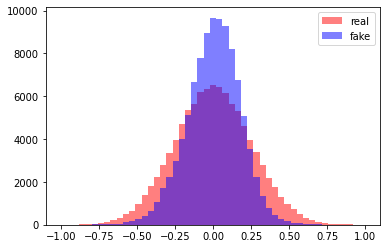

Saved generator to disk
Saved discriminator to disk
epoch:  5499 acc_real:  0.9976400136947632 acc_fake:  0.0002699999895412475


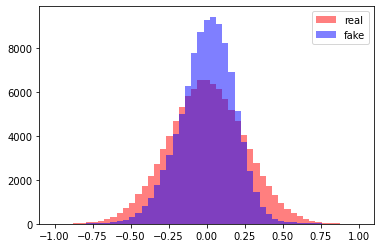

Saved generator to disk
Saved discriminator to disk
epoch:  5749 acc_real:  0.9985700249671936 acc_fake:  9.000000136438757e-05


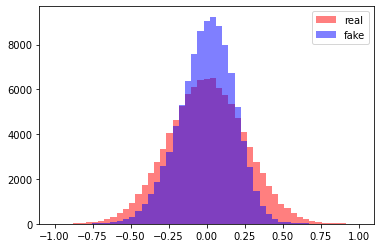

Saved generator to disk
Saved discriminator to disk
epoch:  5999 acc_real:  0.9987099766731262 acc_fake:  1.9999999494757503e-05


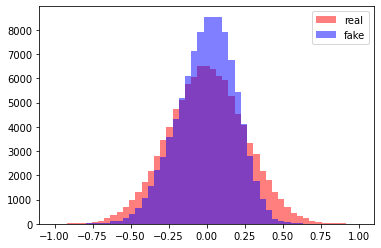

Saved generator to disk
Saved discriminator to disk
epoch:  6249 acc_real:  0.9992499947547913 acc_fake:  0.0


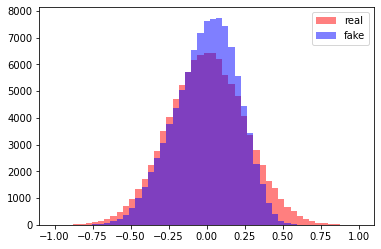

Saved generator to disk
Saved discriminator to disk
epoch:  6499 acc_real:  0.999239981174469 acc_fake:  0.0


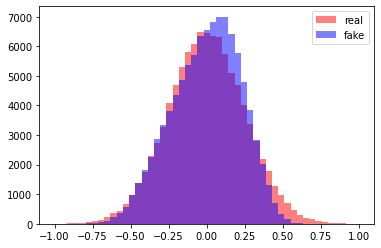

Saved generator to disk
Saved discriminator to disk
epoch:  6749 acc_real:  0.9994699954986572 acc_fake:  0.0


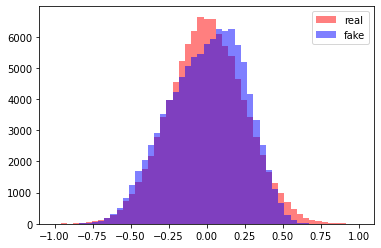

Saved generator to disk
Saved discriminator to disk
epoch:  6999 acc_real:  0.9994099736213684 acc_fake:  0.0


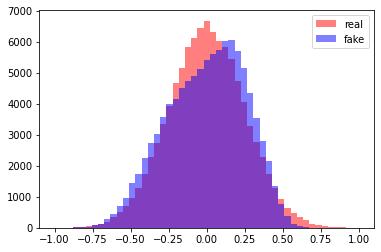

Saved generator to disk
Saved discriminator to disk
epoch:  7249 acc_real:  0.9993900060653687 acc_fake:  0.0


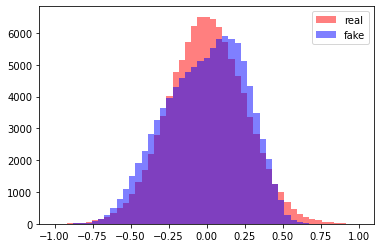

Saved generator to disk
Saved discriminator to disk
epoch:  7499 acc_real:  0.9993900060653687 acc_fake:  0.0


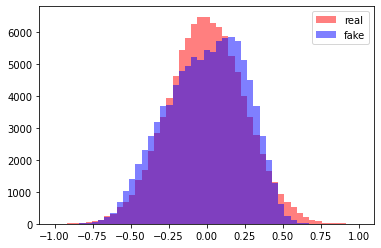

Saved generator to disk
Saved discriminator to disk
epoch:  7749 acc_real:  0.9993799924850464 acc_fake:  0.0


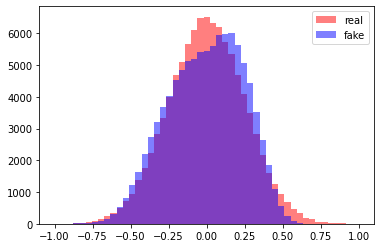

Saved generator to disk
Saved discriminator to disk
epoch:  7999 acc_real:  0.9995099902153015 acc_fake:  9.999999747378752e-06


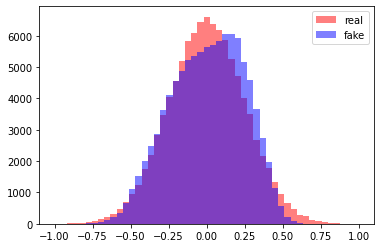

Saved generator to disk
Saved discriminator to disk
epoch:  8249 acc_real:  0.9995099902153015 acc_fake:  0.0


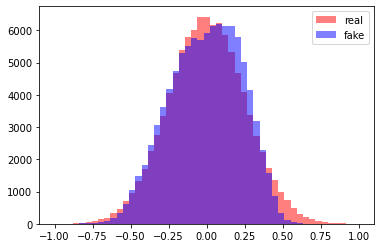

Saved generator to disk
Saved discriminator to disk
epoch:  8499 acc_real:  0.9995399713516235 acc_fake:  0.0


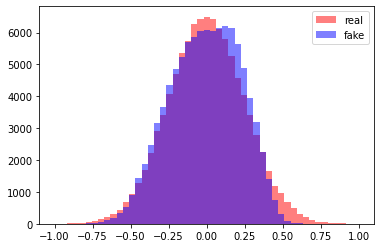

Saved generator to disk
Saved discriminator to disk
epoch:  8749 acc_real:  0.9996200203895569 acc_fake:  0.0


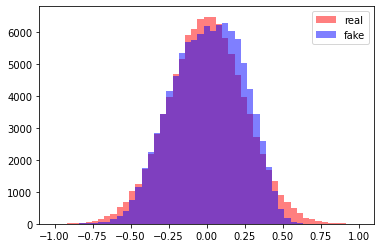

Saved generator to disk
Saved discriminator to disk
epoch:  8999 acc_real:  0.9996100068092346 acc_fake:  0.0


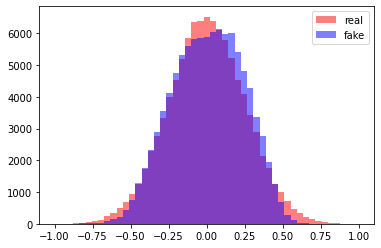

Saved generator to disk
Saved discriminator to disk
epoch:  9249 acc_real:  0.9996600151062012 acc_fake:  1.9999999494757503e-05


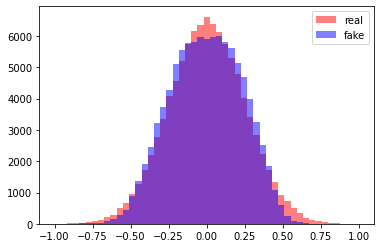

Saved generator to disk
Saved discriminator to disk
epoch:  9499 acc_real:  0.9995800256729126 acc_fake:  9.999999747378752e-06


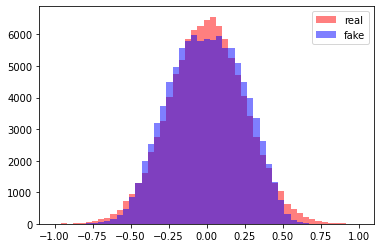

Saved generator to disk
Saved discriminator to disk
epoch:  9749 acc_real:  0.9996700286865234 acc_fake:  0.0


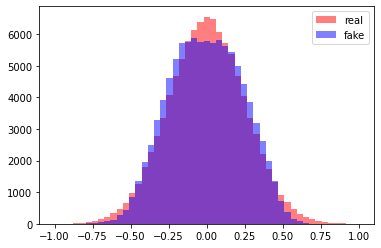

Saved generator to disk
Saved discriminator to disk
epoch:  9999 acc_real:  0.9997100234031677 acc_fake:  0.0


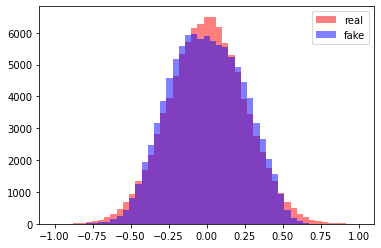

Saved generator to disk
Saved discriminator to disk
epoch:  10249 acc_real:  0.9996600151062012 acc_fake:  9.999999747378752e-06


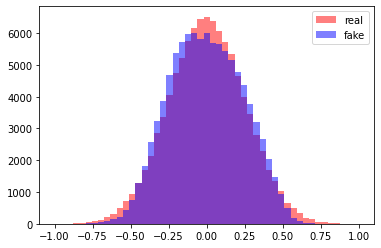

Saved generator to disk
Saved discriminator to disk
epoch:  10499 acc_real:  0.999779999256134 acc_fake:  9.999999747378752e-06


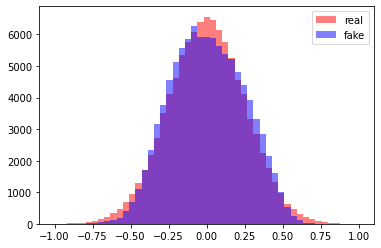

Saved generator to disk
Saved discriminator to disk
epoch:  10749 acc_real:  0.9996100068092346 acc_fake:  0.0


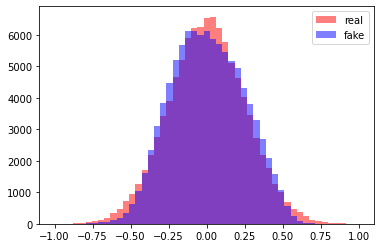

Saved generator to disk
Saved discriminator to disk
epoch:  10999 acc_real:  0.9996700286865234 acc_fake:  0.0


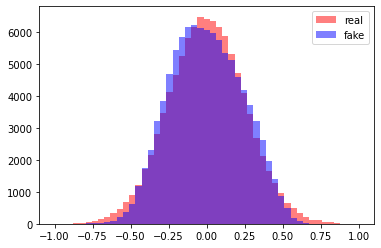

Saved generator to disk
Saved discriminator to disk
epoch:  11249 acc_real:  0.9998300075531006 acc_fake:  0.0


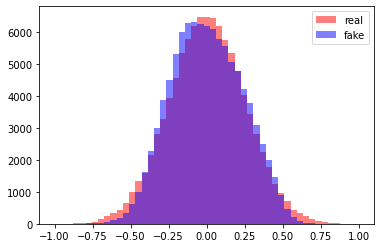

Saved generator to disk
Saved discriminator to disk
epoch:  11499 acc_real:  0.9996399879455566 acc_fake:  9.999999747378752e-06


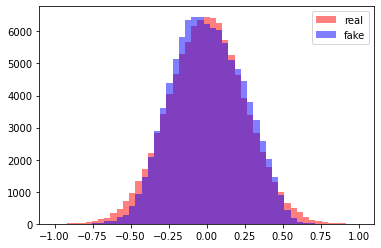

Saved generator to disk
Saved discriminator to disk
epoch:  11749 acc_real:  0.9997299909591675 acc_fake:  0.0


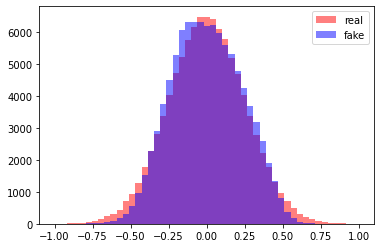

Saved generator to disk
Saved discriminator to disk
epoch:  11999 acc_real:  0.9997900128364563 acc_fake:  0.0


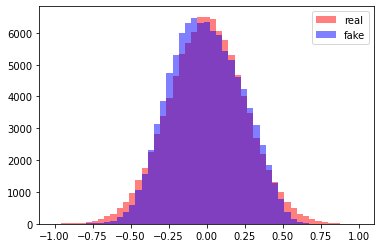

Saved generator to disk
Saved discriminator to disk
epoch:  12249 acc_real:  0.9997199773788452 acc_fake:  9.999999747378752e-06


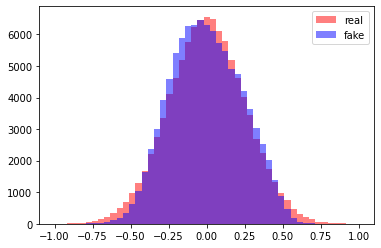

Saved generator to disk
Saved discriminator to disk
epoch:  12499 acc_real:  0.999779999256134 acc_fake:  0.0


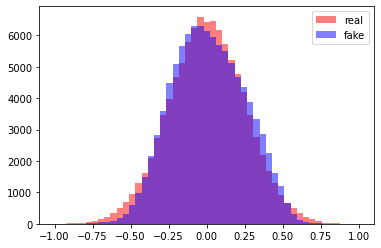

Saved generator to disk
Saved discriminator to disk
epoch:  12749 acc_real:  0.9997100234031677 acc_fake:  0.0


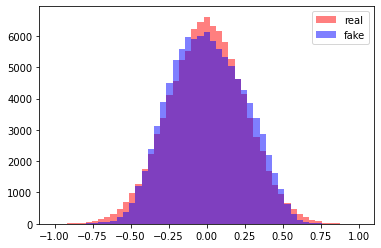

Saved generator to disk
Saved discriminator to disk
epoch:  12999 acc_real:  0.999779999256134 acc_fake:  0.0


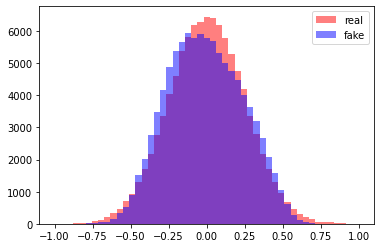

Saved generator to disk
Saved discriminator to disk
epoch:  13249 acc_real:  0.9998199939727783 acc_fake:  0.0


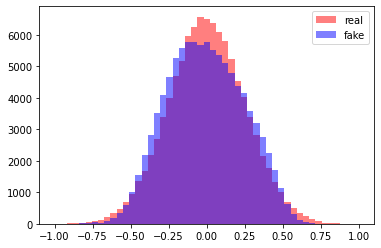

Saved generator to disk
Saved discriminator to disk
epoch:  13499 acc_real:  0.9998199939727783 acc_fake:  0.0


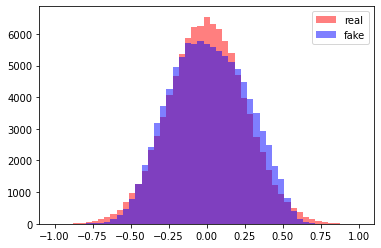

Saved generator to disk
Saved discriminator to disk
epoch:  13749 acc_real:  0.9997000098228455 acc_fake:  0.0


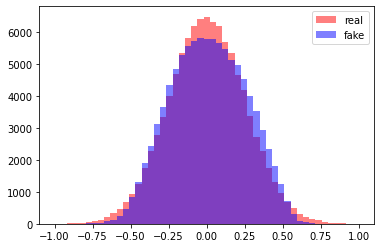

Saved generator to disk
Saved discriminator to disk
epoch:  13999 acc_real:  0.9997400045394897 acc_fake:  0.0


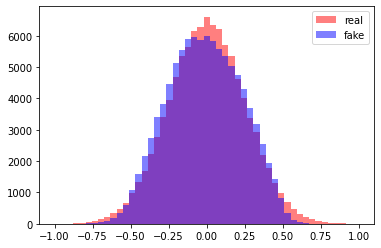

Saved generator to disk
Saved discriminator to disk
epoch:  14249 acc_real:  0.9998000264167786 acc_fake:  0.0


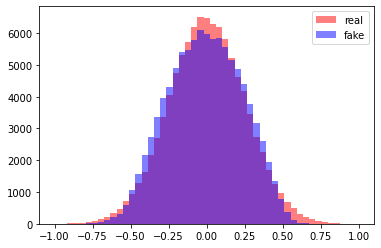

Saved generator to disk
Saved discriminator to disk
epoch:  14499 acc_real:  0.9997100234031677 acc_fake:  0.0


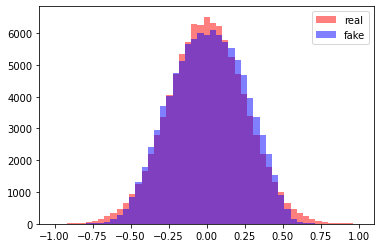

Saved generator to disk
Saved discriminator to disk
epoch:  14749 acc_real:  0.9996100068092346 acc_fake:  0.0


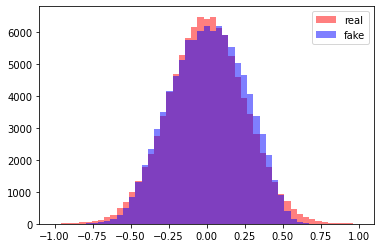

Saved generator to disk
Saved discriminator to disk
epoch:  14999 acc_real:  0.9996700286865234 acc_fake:  0.0


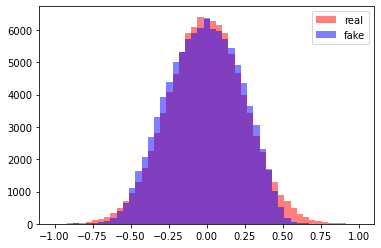

Saved generator to disk
Saved discriminator to disk
epoch:  15249 acc_real:  0.9997599720954895 acc_fake:  0.0


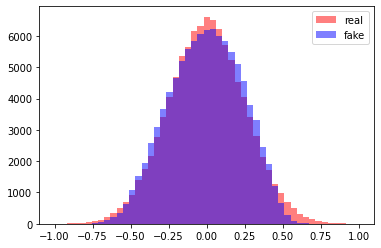

Saved generator to disk
Saved discriminator to disk
epoch:  15499 acc_real:  0.9998499751091003 acc_fake:  0.0


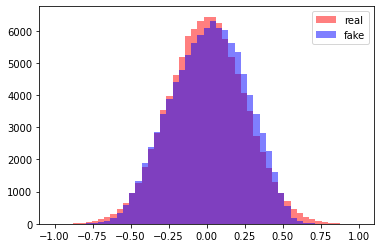

Saved generator to disk
Saved discriminator to disk
epoch:  15749 acc_real:  0.9997100234031677 acc_fake:  0.0


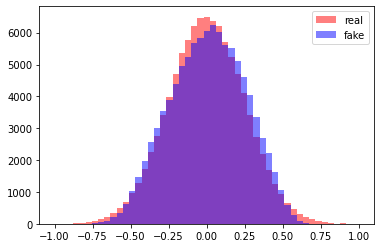

Saved generator to disk
Saved discriminator to disk
epoch:  15999 acc_real:  0.9997599720954895 acc_fake:  0.0


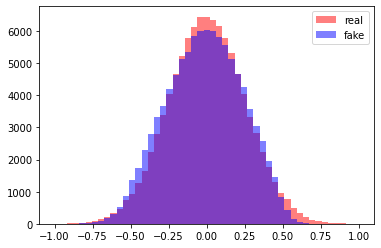

Saved generator to disk
Saved discriminator to disk
epoch:  16249 acc_real:  0.9997900128364563 acc_fake:  0.0


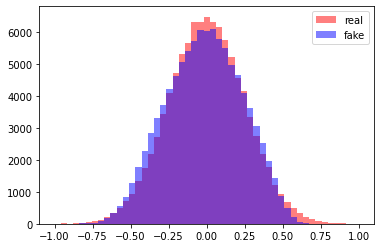

Saved generator to disk
Saved discriminator to disk
epoch:  16499 acc_real:  0.9998300075531006 acc_fake:  0.0


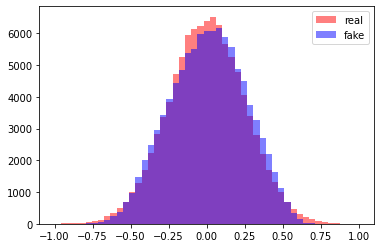

Saved generator to disk
Saved discriminator to disk
epoch:  16749 acc_real:  0.9997900128364563 acc_fake:  0.0


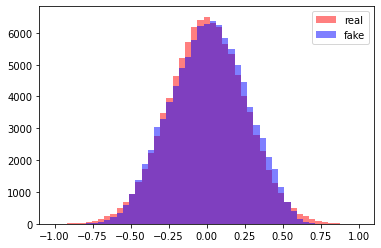

Saved generator to disk
Saved discriminator to disk
epoch:  16999 acc_real:  0.9997100234031677 acc_fake:  0.0


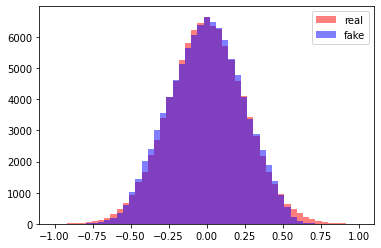

Saved generator to disk
Saved discriminator to disk
epoch:  17249 acc_real:  0.9998400211334229 acc_fake:  0.0


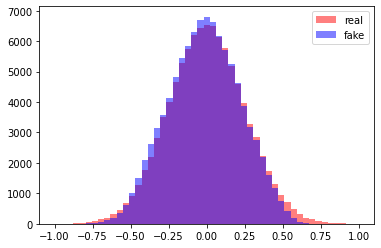

Saved generator to disk
Saved discriminator to disk
epoch:  17499 acc_real:  0.9998800158500671 acc_fake:  0.0


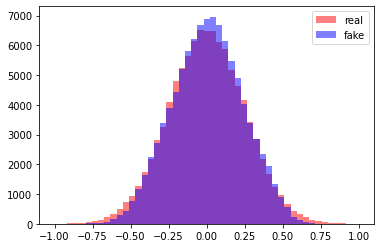

Saved generator to disk
Saved discriminator to disk
epoch:  17749 acc_real:  0.9998800158500671 acc_fake:  0.0


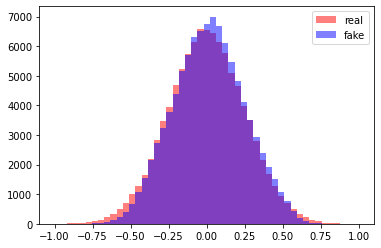

Saved generator to disk
Saved discriminator to disk
epoch:  17999 acc_real:  0.9998599886894226 acc_fake:  0.0


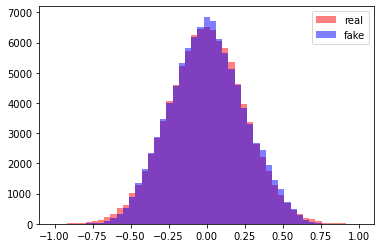

Saved generator to disk
Saved discriminator to disk
epoch:  18249 acc_real:  0.999809980392456 acc_fake:  0.0


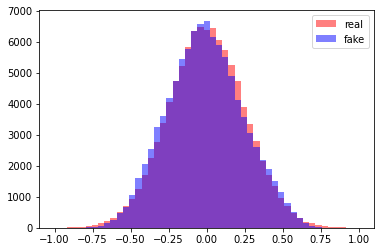

Saved generator to disk
Saved discriminator to disk
epoch:  18499 acc_real:  0.9999399781227112 acc_fake:  0.0


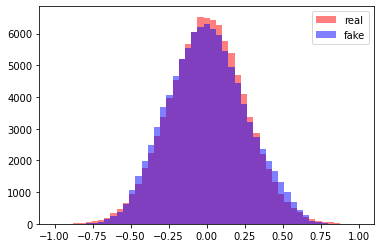

Saved generator to disk
Saved discriminator to disk
epoch:  18749 acc_real:  0.9998599886894226 acc_fake:  0.0


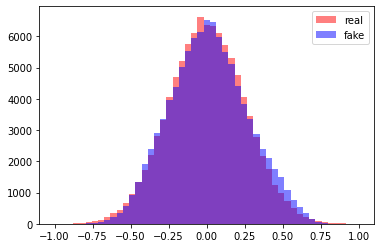

Saved generator to disk
Saved discriminator to disk
epoch:  18999 acc_real:  0.9997299909591675 acc_fake:  0.0


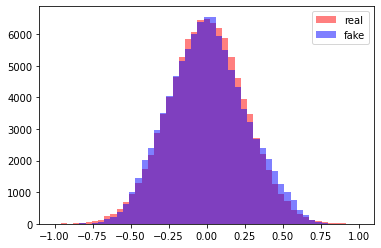

Saved generator to disk
Saved discriminator to disk
epoch:  19249 acc_real:  0.999750018119812 acc_fake:  0.0


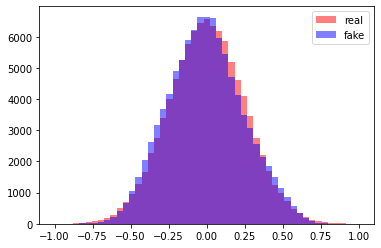

Saved generator to disk
Saved discriminator to disk
epoch:  19499 acc_real:  0.9998499751091003 acc_fake:  9.999999747378752e-06


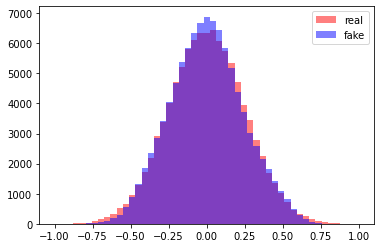

Saved generator to disk
Saved discriminator to disk
epoch:  19749 acc_real:  0.9998000264167786 acc_fake:  0.0


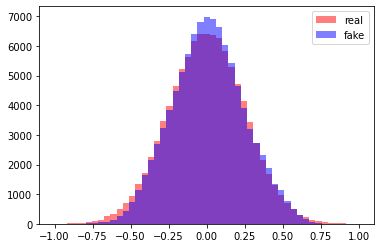

Saved generator to disk
Saved discriminator to disk
epoch:  19999 acc_real:  0.9998300075531006 acc_fake:  0.0


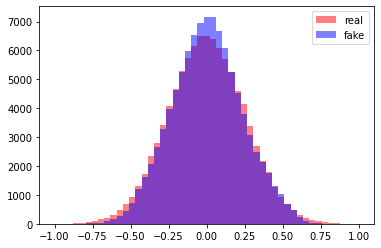

Saved generator to disk
Saved discriminator to disk
epoch:  20249 acc_real:  0.9998599886894226 acc_fake:  0.0


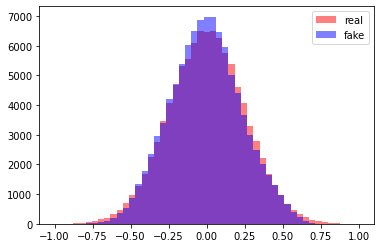

Saved generator to disk
Saved discriminator to disk
epoch:  20499 acc_real:  0.9998300075531006 acc_fake:  0.0


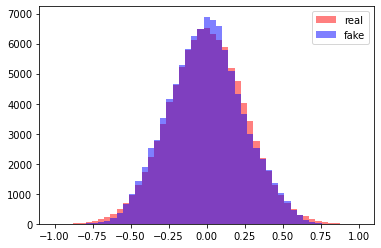

Saved generator to disk
Saved discriminator to disk
epoch:  20749 acc_real:  0.9997699856758118 acc_fake:  0.0


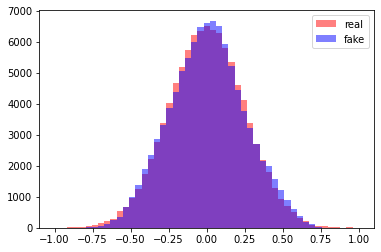

Saved generator to disk
Saved discriminator to disk
epoch:  20999 acc_real:  0.9998599886894226 acc_fake:  0.0


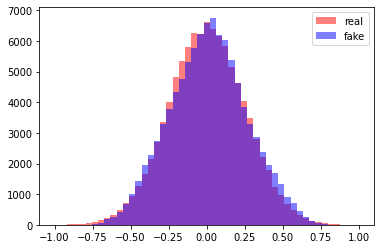

Saved generator to disk
Saved discriminator to disk
epoch:  21249 acc_real:  0.9998700022697449 acc_fake:  0.0


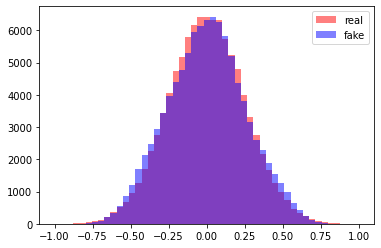

Saved generator to disk
Saved discriminator to disk
epoch:  21499 acc_real:  0.9997599720954895 acc_fake:  0.0


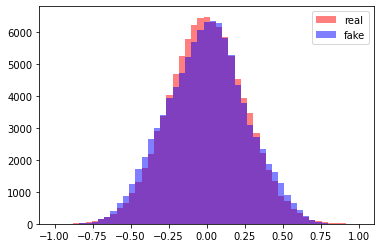

Saved generator to disk
Saved discriminator to disk
epoch:  21749 acc_real:  0.9998400211334229 acc_fake:  0.0


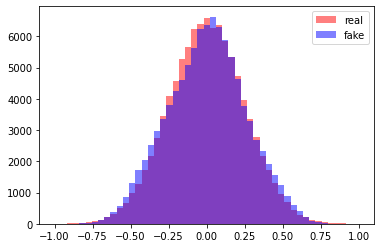

Saved generator to disk
Saved discriminator to disk
epoch:  21999 acc_real:  0.9998000264167786 acc_fake:  0.0


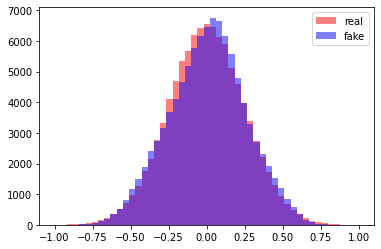

Saved generator to disk
Saved discriminator to disk
epoch:  22249 acc_real:  0.999750018119812 acc_fake:  0.0


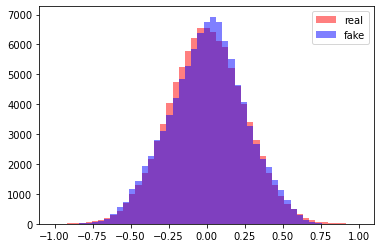

Saved generator to disk
Saved discriminator to disk
epoch:  22499 acc_real:  0.9998300075531006 acc_fake:  0.0


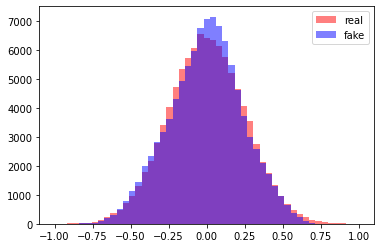

Saved generator to disk
Saved discriminator to disk
epoch:  22749 acc_real:  0.9998199939727783 acc_fake:  0.0


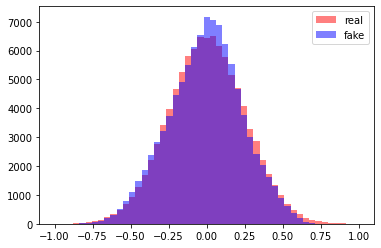

Saved generator to disk
Saved discriminator to disk
epoch:  22999 acc_real:  0.9998599886894226 acc_fake:  0.0


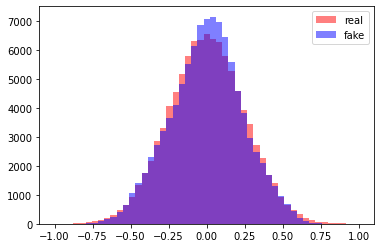

Saved generator to disk
Saved discriminator to disk
epoch:  23249 acc_real:  0.9998900294303894 acc_fake:  0.0


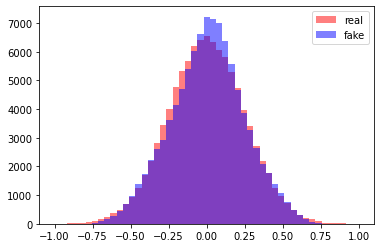

Saved generator to disk
Saved discriminator to disk
epoch:  23499 acc_real:  0.9998700022697449 acc_fake:  0.0


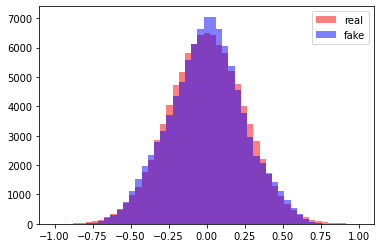

Saved generator to disk
Saved discriminator to disk
epoch:  23749 acc_real:  0.9998999834060669 acc_fake:  0.0


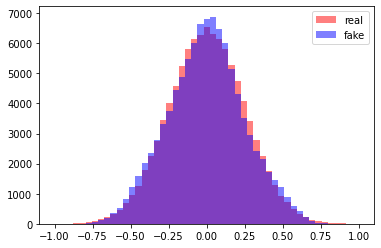

Saved generator to disk
Saved discriminator to disk
epoch:  23999 acc_real:  0.9999200105667114 acc_fake:  0.0


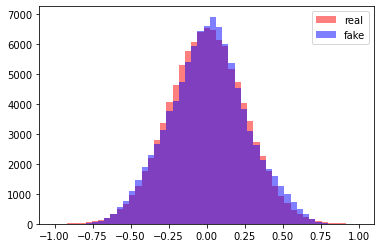

Saved generator to disk
Saved discriminator to disk
epoch:  24249 acc_real:  0.9998300075531006 acc_fake:  0.0


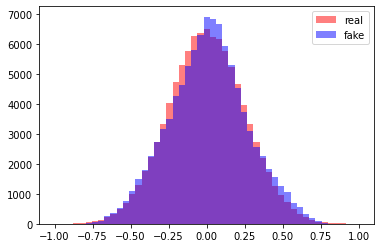

Saved generator to disk
Saved discriminator to disk
epoch:  24499 acc_real:  0.9998000264167786 acc_fake:  0.0


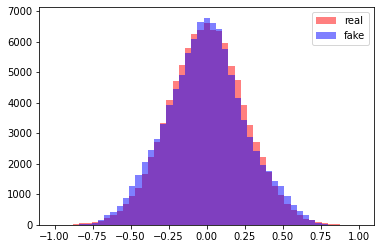

Saved generator to disk
Saved discriminator to disk
epoch:  24749 acc_real:  0.9998300075531006 acc_fake:  0.0


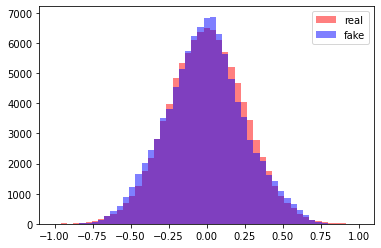

Saved generator to disk
Saved discriminator to disk
epoch:  24999 acc_real:  0.9998499751091003 acc_fake:  0.0


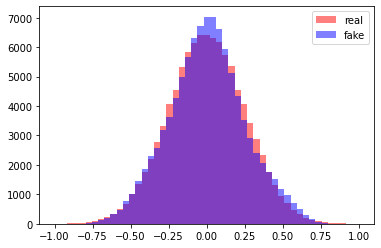

Saved generator to disk
Saved discriminator to disk
epoch:  25249 acc_real:  0.9998499751091003 acc_fake:  0.0


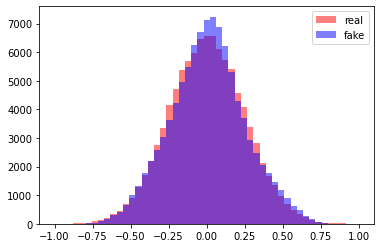

Saved generator to disk
Saved discriminator to disk
epoch:  25499 acc_real:  0.9998700022697449 acc_fake:  0.0


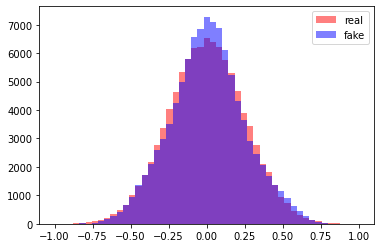

Saved generator to disk
Saved discriminator to disk
epoch:  25749 acc_real:  0.9998199939727783 acc_fake:  0.0


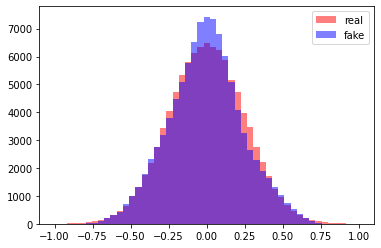

Saved generator to disk
Saved discriminator to disk
epoch:  25999 acc_real:  0.9998599886894226 acc_fake:  0.0


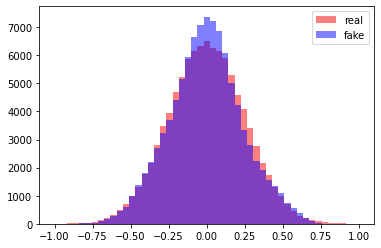

Saved generator to disk
Saved discriminator to disk
epoch:  26249 acc_real:  0.9998599886894226 acc_fake:  0.0


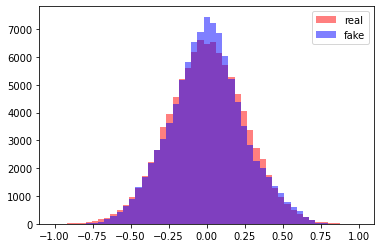

Saved generator to disk
Saved discriminator to disk
epoch:  26499 acc_real:  0.9997900128364563 acc_fake:  9.999999747378752e-06


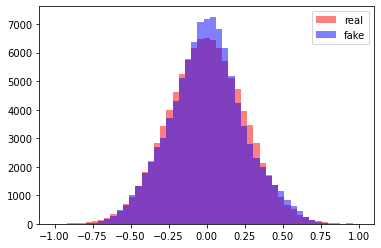

Saved generator to disk
Saved discriminator to disk
epoch:  26749 acc_real:  0.9998499751091003 acc_fake:  0.0


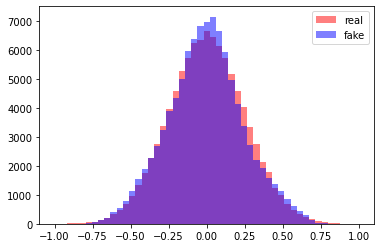

Saved generator to disk
Saved discriminator to disk
epoch:  26999 acc_real:  0.9998800158500671 acc_fake:  9.999999747378752e-06


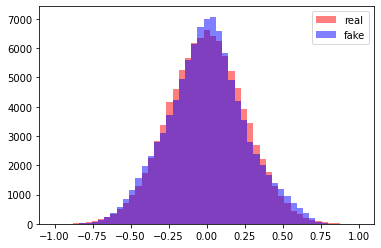

Saved generator to disk
Saved discriminator to disk
epoch:  27249 acc_real:  0.9998499751091003 acc_fake:  0.0


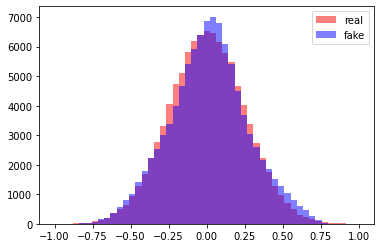

Saved generator to disk
Saved discriminator to disk
epoch:  27499 acc_real:  0.9997699856758118 acc_fake:  0.0


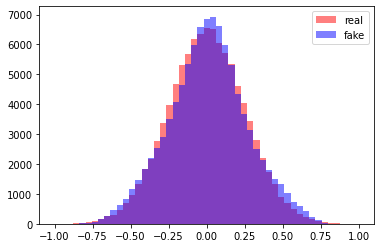

Saved generator to disk
Saved discriminator to disk
epoch:  27749 acc_real:  0.9998400211334229 acc_fake:  9.999999747378752e-06


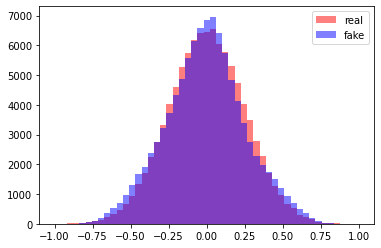

Saved generator to disk
Saved discriminator to disk
epoch:  27999 acc_real:  0.9998400211334229 acc_fake:  0.0


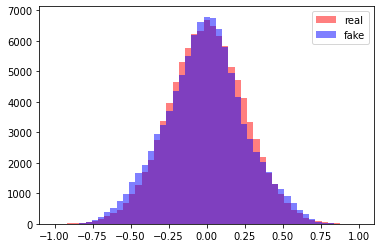

Saved generator to disk
Saved discriminator to disk
epoch:  28249 acc_real:  0.9998700022697449 acc_fake:  0.0


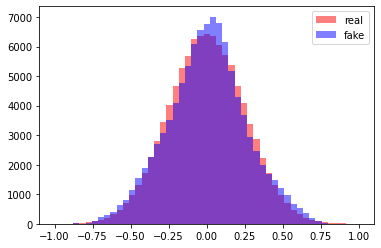

Saved generator to disk
Saved discriminator to disk
epoch:  28499 acc_real:  0.999779999256134 acc_fake:  0.0


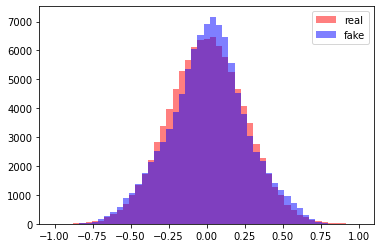

Saved generator to disk
Saved discriminator to disk
epoch:  28749 acc_real:  0.9997599720954895 acc_fake:  0.0


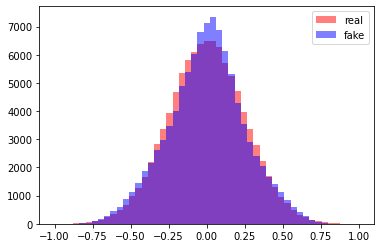

Saved generator to disk
Saved discriminator to disk
epoch:  28999 acc_real:  0.999809980392456 acc_fake:  0.0


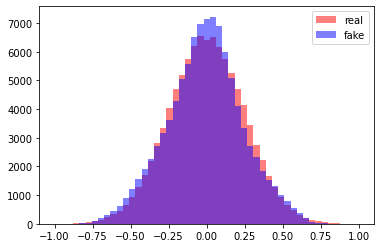

Saved generator to disk
Saved discriminator to disk
epoch:  29249 acc_real:  0.9997900128364563 acc_fake:  0.0


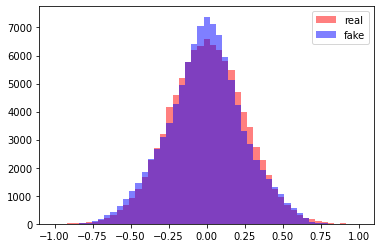

Saved generator to disk
Saved discriminator to disk
epoch:  29499 acc_real:  0.9998499751091003 acc_fake:  0.0


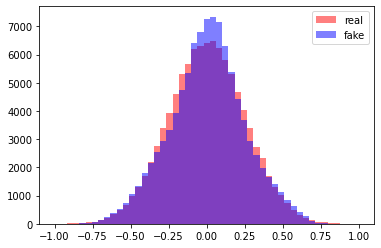

Saved generator to disk
Saved discriminator to disk
epoch:  29749 acc_real:  0.9998199939727783 acc_fake:  0.0


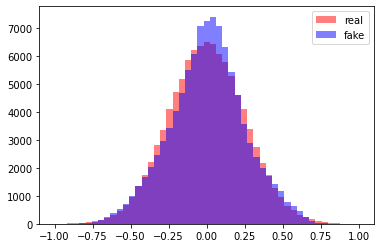

Saved generator to disk
Saved discriminator to disk
epoch:  29999 acc_real:  0.9998700022697449 acc_fake:  0.0


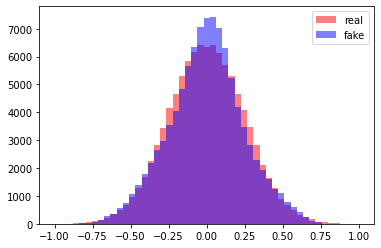

Saved generator to disk
Saved discriminator to disk


In [3]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# serialize generator and discriminator to JSON
gen_model_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(gen_model_json)
disc_model_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(disc_model_json)
# train model
train(generator, discriminator, gan_model, latent_dim)